# Import libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np

# Database creations using pytorch Dataset 

In [4]:
class ImageQualityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        quality = self.data.iloc[idx, 0]  # Quality column
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([quality, authenticity], dtype=torch.float)


        if self.transform:
            image = self.transform(image)

        return image, labels


# Definitions of the models

In [5]:
class VGG16(nn.Module):
    """VGG16 model for image quality assessment."""

    def __init__(self, num_outputs=2):
        """
        Initializes the VGG16 model.

        Args:
            num_outputs (int): Number of output features. Defaults to 2 (quality and authenticity).
        """
        super(VGG16, self).__init__()
        # Load pre-trained VGG16 model
        self.vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)

        # Freeze all layers
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Modify the classifier
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier = nn.Sequential(
            *list(self.vgg16.classifier.children())[:-1],  # Remove last layer with 1000 outputs
            nn.Linear(num_features, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_outputs)  # Add new layer with num_out outputs
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.vgg16(x)
    
class QualityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # Predict quality and realness
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features

# Utility functions for training and evaluation

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Trains the model.

    Args:
        model (nn.Module): The model to train.
        dataloaders (dict): A dictionary containing the training and validation data loaders.
        criterion (nn.Module): The loss function.
        optimizer (optim.Optimizer): The optimizer.
        num_epochs (int): Number of epochs to train for. Defaults to 10.
        device (str): Device to use for training ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        nn.Module: The trained model.
    """
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Iterate over training and validation phases
            print(f'{phase} phase')
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:  # Iterate over data in the current phase
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):  # Enable gradients only during training
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}') # Print loss for the current phase

    print("Finished Training")
    return model

def test_model(model, dataloader, criterion, device='cuda'):

    """
    Tests the model on the test dataset.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The test data loader.
        criterion (nn.Module): The loss function.
        device (str): Device to use for testing ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        float: The average loss on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, _ = model(inputs)
            
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    return test_loss

def get_predictions(model, dataloader, device)-> tuple[torch.Tensor, torch.Tensor]:
    """
    Get predictions from the model.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The data loader.

    Returns:
        tuple: A tuple (predictions, labels) where:
            predictions (torch.Tensor): Predictions from the model.
            labels (torch.Tensor): Ground truth labels.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    predictions = []
    labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, target in dataloader:
            outputs, _ = model(inputs.to(device))
            predictions.append(outputs)
            labels.append(target)

    #move to cpu and concatenate
    predictions = torch.cat(predictions).cpu()
    labels = torch.cat(labels).cpu()

    return predictions, labels

def get_regression_errors(tuple: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Get regression errors.

    Args:
        tuple: A tuple (predictions, labels) where:
            predictions (torch.Tensor): Predictions from the model.
            labels (torch.Tensor): Ground truth labels.

    Returns:
        tuple: A tuple (quality_errors, authenticity_errors) where:
            quality_errors (torch.Tensor): Quality errors.
            authenticity_errors (torch.Tensor): Authenticity errors.
    """
    predictions, labels = tuple
    quality_errors = predictions[:, 0] - labels[:, 0]
    authenticity_errors = predictions[:, 1] - labels[:, 1]
    return quality_errors, authenticity_errors

def get_rmse(errors: torch.Tensor) -> torch.Tensor:
    """
    Get the root mean squared error.

    Args:
        errors (torch.Tensor): Errors.

    Returns:
        torch.Tensor: Root mean squared error.
    """
    return torch.sqrt(torch.mean(errors ** 2))


## Training section

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annotations_file = 'Dataset/AIGCIQA2023/mos_data.csv'

# Create the dataset
dataset = ImageQualityDataset(csv_file=annotations_file, transform=data_transforms)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 64
EPOCHS = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create a dictionary containing the data loaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}

model = QualityPredictor()
criterion = nn.MSELoss()  # Mean Squared Error Loss (regression)
optimizer = optim.Adam(model.regression_head.parameters(), lr=0.001)

model_path = 'Models/VGG-16_finetuned_regression.pth'


## Train 

In [ ]:
quality_predictor_trained= train_model(model, dataloaders, criterion, optimizer, EPOCHS, device)

# Save the trained model
torch.save(quality_predictor_trained.state_dict(), model_path)

# Load the trained model
quality_predictor_trained = QualityPredictor()
quality_predictor_trained.load_state_dict(torch.load(model_path))

## Utilities for pruning 

In [7]:
def compute_feature_map_importance(model, dataloader, device, layer_name) -> tuple[np.ndarray, np.ndarray]:
    """Computes the importance of each feature map in a convolution
    layer by measuring the change in predictions when the feature map is zero
    out.
    
    Returns:
        tuple: (indices, importance_scores) where both are numpy arrays
    """
    #if importance_scores.npy exists, load it
    if os.path.exists('importance_scores.npy'):
        return np.load('importance_scores.npy')
    
    model.eval()
    model.to(device)
    importance_scores = []
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
    baseline_predictions = get_predictions(model, dataloader, device)
    regression_errors = get_regression_errors(baseline_predictions)
    quality_errors, authenticity_errors = regression_errors
    baseline_quality_rmse = get_rmse(quality_errors)
    baseline_authenticity_rmse = get_rmse(authenticity_errors)
    average_baseline_rmse = (baseline_quality_rmse + baseline_authenticity_rmse) / 2

    
    print(f'Average baseline RMSE: {average_baseline_rmse:.4f}')

    with torch.no_grad():
        for i in range(layer.out_channels):
            # Create a backup of the weights and bias
            backup_weights = layer.weight[i, ...].clone()
            backup_bias = layer.bias[i].clone() if layer.bias is not None else None

            # Zero out the i-th output channel
            layer.weight[i, ...] = 0
            if layer.bias is not None:
                layer.bias[i] = 0

            # Get predictions with the pruned feature map
            pruned_predictions = get_predictions(model, dataloader, device)
            pruned_regression_errors = get_regression_errors(pruned_predictions)
            pruned_quality_errors, pruned_authenticity_errors = pruned_regression_errors
            pruned_quality_rmse = get_rmse(pruned_quality_errors)
            pruned_authenticity_rmse = get_rmse(pruned_authenticity_errors)
            average_pruned_rmse = (pruned_quality_rmse + pruned_authenticity_rmse) / 2
    
            # Compute importance score
            importance_score = average_baseline_rmse - average_pruned_rmse
            importance_scores.append([i, importance_score])
            

            print(f'Feature map {i}: Importance score: {importance_score:.4f}')
            
            # After computing importance, restore weights and bias
            layer.weight[i, ...] = backup_weights
            if layer.bias is not None:
                layer.bias[i] = backup_bias 

    sorted_importance_scores = sorted(importance_scores, key=lambda x: x[1], reverse=True)
    # save np array 
    np.save('importance_scores.npy', sorted_importance_scores)
    return np.array(sorted_importance_scores)

def find_optimal_feature_subset(model, dataloader, device, layer_name, sorted_importance_scores, model_path='Models/pruned_model.pth'):
    """
    Find an optimal subset of feature maps by iteratively adding features in order of importance
    and tracking model performance, keeping the subset that maximizes performance.
    
    Args:
        model: The neural network model
        dataloader: DataLoader for evaluation
        device: Device to run the model on (cuda/cpu)
        layer_name: Name of the layer to optimize
        sorted_importance_scores: List of tuples (channel_index, importance_score) sorted by importance
        
    Returns:
        Dictionary with optimal subset and performance metrics
    """
    model.eval()
    model.to(device)
    
    # Reverse the sorted importance scores
    sorted_importance_scores = sorted_importance_scores[::-1]
    
    # Get the target layer
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
    
    # Create a backup of the original weights and bias
    original_weights = layer.weight.clone()
    original_bias = layer.bias.clone() if layer.bias is not None else None
    
    # Initialize tracking variables
    best_rmse = float('inf')
    best_subset = []
    rmse_history = []
    current_subset = []
    
    # Get baseline with no features (all zeroed out)
    layer.weight.data.fill_(0)
    if layer.bias is not None:
        layer.bias.data.fill_(0)
        
    baseline_predictions = get_predictions(model, dataloader, device)
    baseline_regression_errors = get_regression_errors(baseline_predictions)
    baseline_quality_errors, baseline_authenticity_errors = baseline_regression_errors
    baseline_quality_rmse = get_rmse(baseline_quality_errors)
    baseline_authenticity_rmse = get_rmse(baseline_authenticity_errors)
    baseline_rmse = (baseline_quality_rmse + baseline_authenticity_rmse) / 2
    
    print(f"Baseline RMSE (no features): {baseline_rmse:.4f}")
    print("------------------")
    
    # Track performance with empty set
    rmse_history.append(([], baseline_rmse))
    
    # Iteratively add feature maps in order of importance
    for idx, (channel_idx, _) in enumerate(sorted_importance_scores):
        channel_idx = int(channel_idx)
        
        # Add this feature map to the current subset
        current_subset.append(channel_idx)
        
        # Reset all weights to zero first
        layer.weight.data.fill_(0)
        if layer.bias is not None:
            layer.bias.data.fill_(0)
        
        # Enable only the feature maps in the current subset
        for ch_idx in current_subset:
            layer.weight[ch_idx, ...] = original_weights[ch_idx, ...]
            if layer.bias is not None:
                layer.bias[ch_idx] = original_bias[ch_idx]
        
        # Evaluate model with current subset
        predictions = get_predictions(model, dataloader, device)
        regression_errors = get_regression_errors(predictions)
        quality_errors, authenticity_errors = regression_errors
        quality_rmse = get_rmse(quality_errors)
        authenticity_rmse = get_rmse(authenticity_errors)
        current_rmse = (quality_rmse + authenticity_rmse) / 2
        
        # Record performance
        rmse_history.append((current_subset.copy(), current_rmse))
        
        print(f"Iteration {idx+1}/{len(sorted_importance_scores)}: " +
              f"Added channel {channel_idx}, " +
              f"Subset size: {len(current_subset)}, " +
              f"RMSE: {current_rmse:.4f}")
        
        # Update best subset if this one is better
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_subset = current_subset.copy()
            print(f"  ✓ New best subset found! RMSE: {best_rmse:.4f}")
    
    print("\n------------------")
    print(f"Best RMSE: {best_rmse:.4f} with {len(best_subset)} features")
    print(f"Improvement over baseline: {baseline_rmse - best_rmse:.4f}")
    print(f"Feature reduction: {(1 - len(best_subset)/len(sorted_importance_scores))*100:.1f}%")
    
    # Apply the best subset to the model
    layer.weight.data.fill_(0)
    if layer.bias is not None:
        layer.bias.data.fill_(0)
        
    for ch_idx in best_subset:
        layer.weight[ch_idx, ...] = original_weights[ch_idx, ...]
        if layer.bias is not None:
            layer.bias[ch_idx] = original_bias[ch_idx]
    
    # Save the pruned model
    torch.save(model.state_dict(), model_path)
    
    # Restore original weights for future use
    layer.weight.data.copy_(original_weights)
    if layer.bias is not None:
        layer.bias.data.copy_(original_bias)
    
    return {
        'best_subset': best_subset,
        'best_rmse': best_rmse,
        'baseline_rmse': baseline_rmse,
        'improvement': baseline_rmse - best_rmse,
        'reduction_percentage': (1 - len(best_subset)/len(sorted_importance_scores))*100,
        'rmse_history': rmse_history
    }

def remove_noisy_feature_maps(model, dataloader, device, layer_name, sorted_importance_scores, model_path='Models/pruned_model.pth'):
    """
    Remove noisy feature maps from a convolutional layer based on importance scores.
    Feature maps are zeroed out one by one and kept zeroed only if model performance improves.
    
    Args:
        model: The neural network model
        dataloader: DataLoader for evaluation
        device: Device to run the model on (cuda/cpu)
        layer_name: Name of the layer to optimize
        sorted_importance_scores: List of tuples (channel_index, importance_score) sorted by importance
        
    Returns:
        Dictionary with pruning results and performance metrics
    """
    model.eval()
    model.to(device)
    
    # Get the target layer
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
    
    # Create a backup of the original weights and bias
    original_weights = layer.weight.clone()
    original_bias = layer.bias.clone() if layer.bias is not None else None
    
    # Initialize tracking variables
    removed_features = []
    rmse_history = []
    
    # Get baseline performance
    baseline_predictions = get_predictions(model, dataloader, device)
    baseline_regression_errors = get_regression_errors(baseline_predictions)
    baseline_quality_errors, baseline_authenticity_errors = baseline_regression_errors
    baseline_quality_rmse = get_rmse(baseline_quality_errors)
    baseline_authenticity_rmse = get_rmse(baseline_authenticity_errors)
    average_baseline_rmse = (baseline_quality_rmse + baseline_authenticity_rmse) / 2
    
    print(f"Baseline RMSE: {average_baseline_rmse:.4f}")
    print("------------------")
    
    # Track initial performance
    rmse_history.append(([], average_baseline_rmse))
    baseline_rmse = average_baseline_rmse
    
    # Iterate over the sorted indices and if removing a feature map improves performance, keep it removed
    for idx, (channel_idx, importance_score) in enumerate(sorted_importance_scores):
        channel_idx = int(channel_idx)
        
        # Temporarily zero out this feature map
        layer.weight[channel_idx, ...] = 0
        if layer.bias is not None:
            layer.bias[channel_idx] = 0
        
        # Evaluate model with feature map removed
        predictions = get_predictions(model, dataloader, device)
        regression_errors = get_regression_errors(predictions)
        quality_errors, authenticity_errors = regression_errors
        quality_rmse = get_rmse(quality_errors)
        authenticity_rmse = get_rmse(authenticity_errors)
        average_new_rmse = (quality_rmse + authenticity_rmse) / 2
        
        print(f"Iteration {idx+1}/{len(sorted_importance_scores)}: " +
              f"Testing removal of channel {channel_idx}, " +
              f"Importance: {importance_score:.4f}, " +
              f"RMSE: {average_new_rmse:.4f}")
        
        # Decide whether to keep this feature map removed
        if average_new_rmse < baseline_rmse:
            baseline_rmse = average_new_rmse if average_new_rmse < average_baseline_rmse else average_baseline_rmse
            removed_features.append(channel_idx)
            rmse_history.append((removed_features.copy(), baseline_rmse))
            print(f"  ✓ IMPROVING: Zeroing out feature map {channel_idx}")
        else:
            # Restore the feature map
            layer.weight[channel_idx, ...] = original_weights[channel_idx, ...]
            if layer.bias is not None:
                layer.bias[channel_idx] = original_bias[channel_idx]
            print(f"  ✗ NOT IMPROVING: Keeping feature map {channel_idx}")
        
        print(f"  Current best RMSE: {baseline_rmse:.4f}")
        print("------------------")
    
    # Final statistics
    print("\n------------------")
    print(f"Final RMSE: {baseline_rmse:.4f} after removing {len(removed_features)} feature maps")
    print(f"Improvement over baseline: {average_baseline_rmse - baseline_rmse:.4f}")
    print(f"Feature reduction: {(len(removed_features)/len(sorted_importance_scores))*100:.1f}%")
    
    # Save the pruned model
    torch.save(model.state_dict(), model_path)
    
    return {
        'removed_features': removed_features,
        'baseline_rmse': average_baseline_rmse,
        'final_rmse': baseline_rmse,
        'improvement': average_baseline_rmse - baseline_rmse,
        'reduction_percentage': (len(removed_features)/len(sorted_importance_scores))*100,
        'rmse_history': rmse_history
    }

def remove_negative_impact_feature_maps(model, dataloader, device, layer_name, sorted_importance_scores, model_path='Models/negative_impact_pruned_model.pth'):
    """
    Remove feature maps that have a negative impact on model performance based on importance scores (impotance score < 0).
    
    Args:
        model: The neural network model
        dataloader: DataLoader for evaluation
        device: Device to run the model on (cuda/cpu)
        layer_name: Name of the layer to optimize
        sorted_importance_scores: List of tuples (channel_index, importance_score) sorted by importance
        
    Returns:
        Dictionary with pruning results and performance metrics
    """
    model.eval()
    model.to(device)
    
    # Get the target layer
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
    
    # Create a backup of the original weights and bias
    original_weights = layer.weight.clone()
    original_bias = layer.bias.clone() if layer.bias is not None else None
    
    # Get baseline performance
    predictions = get_predictions(model, dataloader, device)
    regression_errors = get_regression_errors(predictions)
    quality_errors, authenticity_errors = regression_errors
    quality_rmse = get_rmse(quality_errors)
    authenticity_rmse = get_rmse(authenticity_errors)
    baseline_rmse = (quality_rmse + authenticity_rmse) / 2

    # Initialize tracking variables
    removed_features = []
    
    # Iterate over the sorted indices and zero out all the feature maps that have a negative impact (importance < 0)

    for idx, (channel_idx, importance_score) in enumerate(sorted_importance_scores):
        print(f"Iteration {idx} - Channel {channel_idx}: Importance score: {importance_score:.4f}")
        if importance_score < 0:
            channel_idx = int(channel_idx)
            layer.weight[channel_idx, ...] = 0
            if layer.bias is not None:
                layer.bias[channel_idx] = 0
            removed_features.append(channel_idx)

    # Evaluate model with feature maps removed
    new_predictions = get_predictions(model, dataloader, device)
    new_regression_errors = get_regression_errors(new_predictions)
    new_quality_errors, new_authenticity_errors = new_regression_errors
    new_quality_rmse = get_rmse(new_quality_errors)
    new_authenticity_rmse = get_rmse(new_authenticity_errors)
    new_rmse = (new_quality_rmse + new_authenticity_rmse) / 2

    # Save the pruned model
    torch.save(model.state_dict(), model_path)

    # Restore original weights for future use
    layer.weight.data.copy_(original_weights)
    if layer.bias is not None:
        layer.bias.data.copy_(original_bias)

    
    return {
        'removed_features': removed_features,
        'baseline_rmse': baseline_rmse,
        'final_rmse': new_rmse,
        'improvement': baseline_rmse - new_rmse,
        'reduction_percentage': (len(removed_features)/len(sorted_importance_scores))*100
    }

def remove_channels(model,device,layer_name,channels_indexes)->QualityPredictor:
    """
    Remove channels, using an index list, from a convolutional layer in a model.
    
    Args:
        model: The neural network model
        device: Device to run the model on (cuda/cpu)
        layer_name: Name of the layer to optimize
        channels_indexes: List of channel indexes to remove
        
    Returns:
        The pruned model
    """
    model.eval()
    model.to(device)
    
    # Get the target layer
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
        
    # Zero out the specified channels
    for channel_idx in channels_indexes:
        layer.weight[channel_idx, ...] = 0
        if layer.bias is not None:
            layer.bias[channel_idx] = 0
    
    return model

# Creation of diffrent models using different pruning techniques

- Deletion of models is due to make sure that im not using the same model again and again (first draft, not sure if im correctlly restoring weights in each pruning technique)

In [8]:
# LAYER to prune
LAYER = 'features.28'
DEVICE = 'cuda'

# Base model for importance score computation
base_model = QualityPredictor()
base_model.load_state_dict(torch.load('Models/VGG-16_finetuned_regression.pth'))
base_model.eval()
base_model.to(DEVICE)

sorted_importance_scores = compute_feature_map_importance(base_model, train_dataloader, DEVICE, LAYER)
del base_model

# Model for noisy feature maps removal
noisy_pruning_model = QualityPredictor()
noisy_pruning_model.load_state_dict(torch.load('Models/VGG-16_finetuned_regression.pth'))
noisy_pruning_model.eval()
noisy_pruning_model.to(DEVICE)

noisy_optimal_subset = remove_noisy_feature_maps(noisy_pruning_model, train_dataloader, DEVICE, LAYER, sorted_importance_scores, model_path='Models/noise_out_pruned_model.pth')

del noisy_pruning_model

# Model for optimal subset selection
optimal_subset_model = QualityPredictor()
optimal_subset_model.load_state_dict(torch.load('Models/VGG-16_finetuned_regression.pth'))
optimal_subset_model.eval()
optimal_subset_model.to(DEVICE)

# Find the optimal subset of feature maps
optimal_subset = find_optimal_feature_subset(optimal_subset_model, train_dataloader, DEVICE, LAYER, sorted_importance_scores, model_path='Models/optimal_set_pruned_model.pth')

# Model for negative impact feature maps removal
negative_impact_model = QualityPredictor()
negative_impact_model.load_state_dict(torch.load('Models/VGG-16_finetuned_regression.pth'))
negative_impact_model.eval()
negative_impact_model.to(DEVICE)

negative_impact_subset = remove_negative_impact_feature_maps(negative_impact_model, train_dataloader, DEVICE, LAYER, sorted_importance_scores, model_path='Models/negative_impact_pruned_model.pth')

del negative_impact_model


/tmp/ipykernel_4178516/351979307.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load('Models/VGG-16_finetuned_regression.pth'))


KeyboardInterrupt: 

# Testing with already saved weights

In [10]:
NOISY_PRUNED_MODEL_PATH = 'Models/noise_out_pruned_model.pth'
BEST_SUBSET_PRUNED_MODEL_PATH = 'Models/optimal_set_pruned_model.pth'
NEGATIVE_IMPACT_PRUNED_MODEL_PATH = 'Models/negative_impact_pruned_model.pth'

noisy_pruned_model = QualityPredictor()
noisy_pruned_model.load_state_dict(torch.load(NOISY_PRUNED_MODEL_PATH, weights_only=True))

best_subset_pruned_model = QualityPredictor()
best_subset_pruned_model.load_state_dict(torch.load(BEST_SUBSET_PRUNED_MODEL_PATH, weights_only=True))

negative_impact_pruned_model = QualityPredictor()
negative_impact_pruned_model.load_state_dict(torch.load(NEGATIVE_IMPACT_PRUNED_MODEL_PATH,weights_only=True))

baseline_model = QualityPredictor()
baseline_model.load_state_dict(torch.load('Models/VGG-16_finetuned_regression.pth',weights_only=True))

# Testing

# Test the baseline model
print("Testing the baseline model")
test_model(baseline_model, test_dataloader, criterion, device)
print("------------------")
# test the noisy pruned model
print("Testing the noisy pruned model")
test_model(noisy_pruned_model, test_dataloader, criterion, device)
print("------------------")
# test the best subset pruned model
print("Testing the best subset pruned model")
test_model(best_subset_pruned_model, test_dataloader, criterion, device)
print("------------------")
# test the negative impact pruned model
print("Testing the negative impact pruned model")
test_model(negative_impact_pruned_model, test_dataloader, criterion, device)
print("------------------")


Testing the baseline model
Test Loss: 128.1473
------------------
Testing the noisy pruned model
Test Loss: 78.7903
------------------
Testing the best subset pruned model
Test Loss: 85.0760
------------------
Testing the negative impact pruned model
Test Loss: 118.6197
------------------


# Final Aanalysis - Comparing the models zeroed out weights & Correlations between the models predicitons and ground truth

## Zero-out weights analysis

In [10]:
# Create a function that extract the indices of the zeroed out feature maps in a convolutional layer

def get_zeroed_feature_maps(model, layer_name):
    """
    Get the indices of the zeroed out feature maps in a convolutional layer.

    Args:
        model (nn.Module): The neural network model.
        layer_name (str): The name of the convolutional layer.

    Returns:
        list: The indices of the zeroed out feature maps.
    """
    dict_modules = dict(model.named_modules())
    layer = dict_modules[layer_name]
    zeroed_feature_maps = []

    for i, weight in enumerate(layer.weight):
        if torch.all(weight == 0):
            zeroed_feature_maps.append(i)
    zeroed_feature_maps.sort()

    num_zeroed = len(zeroed_feature_maps)

    return zeroed_feature_maps, num_zeroed

# Get the zeroed out feature maps in the 'features.28' layer of the noisy pruned model
_, noisy_num_zeroed = get_zeroed_feature_maps(noisy_pruned_model, 'features.28')

# Get the zeroed out feature maps in the 'features.28' layer of the best subset pruned model
_, best_subset_num_zeroed = get_zeroed_feature_maps(best_subset_pruned_model, 'features.28')

# Get the zeroed out feature maps in the 'features.28' layer of the negative impact pruned model
_, negative_impact_num_zeroed = get_zeroed_feature_maps(negative_impact_pruned_model, 'features.28')

print(f"Noisy pruned model: {noisy_num_zeroed} zeroed out feature maps")
print(f"Best subset pruned model: {best_subset_num_zeroed} zeroed out feature maps")
print(f"Negative impact pruned model: {negative_impact_num_zeroed} zeroed out feature maps")


Noisy pruned model: 133 zeroed out feature maps
Best subset pruned model: 43 zeroed out feature maps
Negative impact pruned model: 185 zeroed out feature maps


## Correlation analysis

TypeError: pred_vs_error_plot() missing 2 required positional arguments: 'dataloader' and 'device'

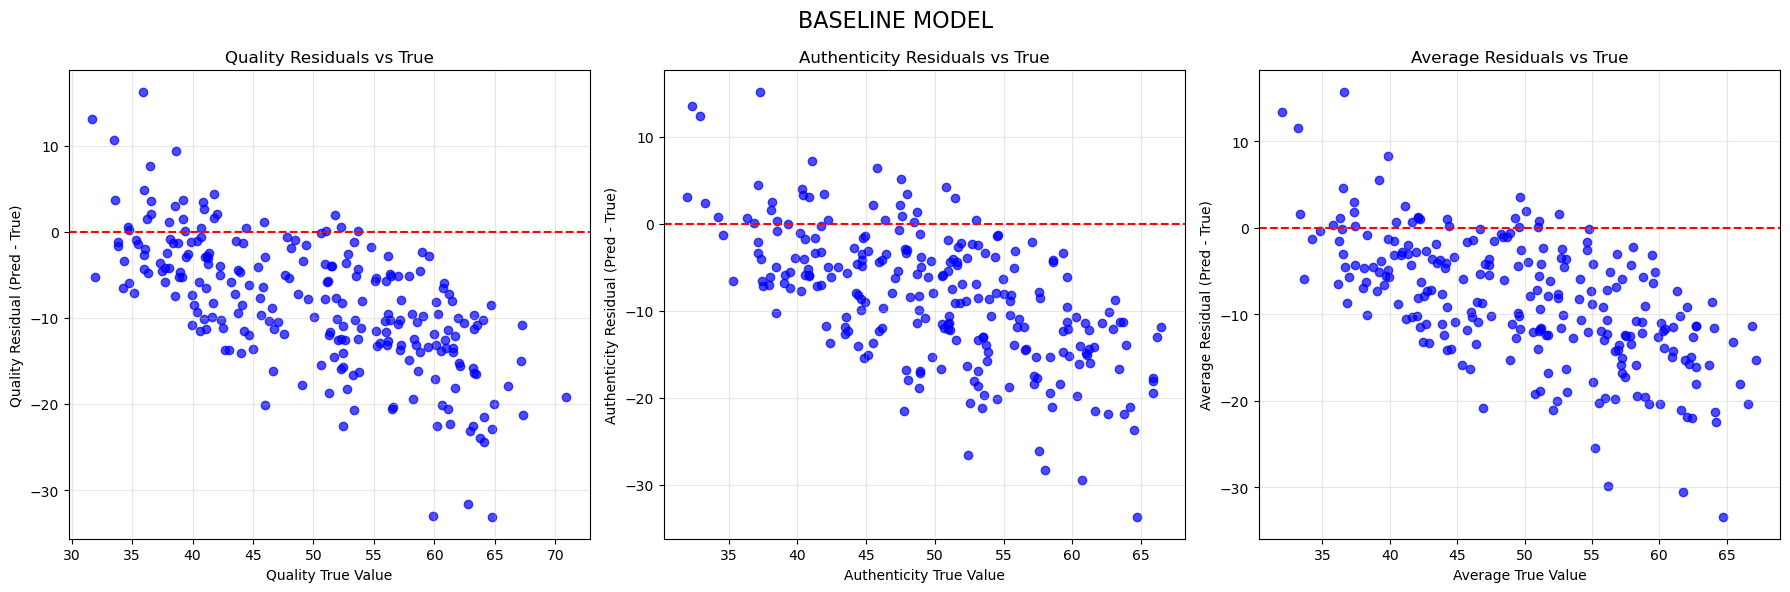

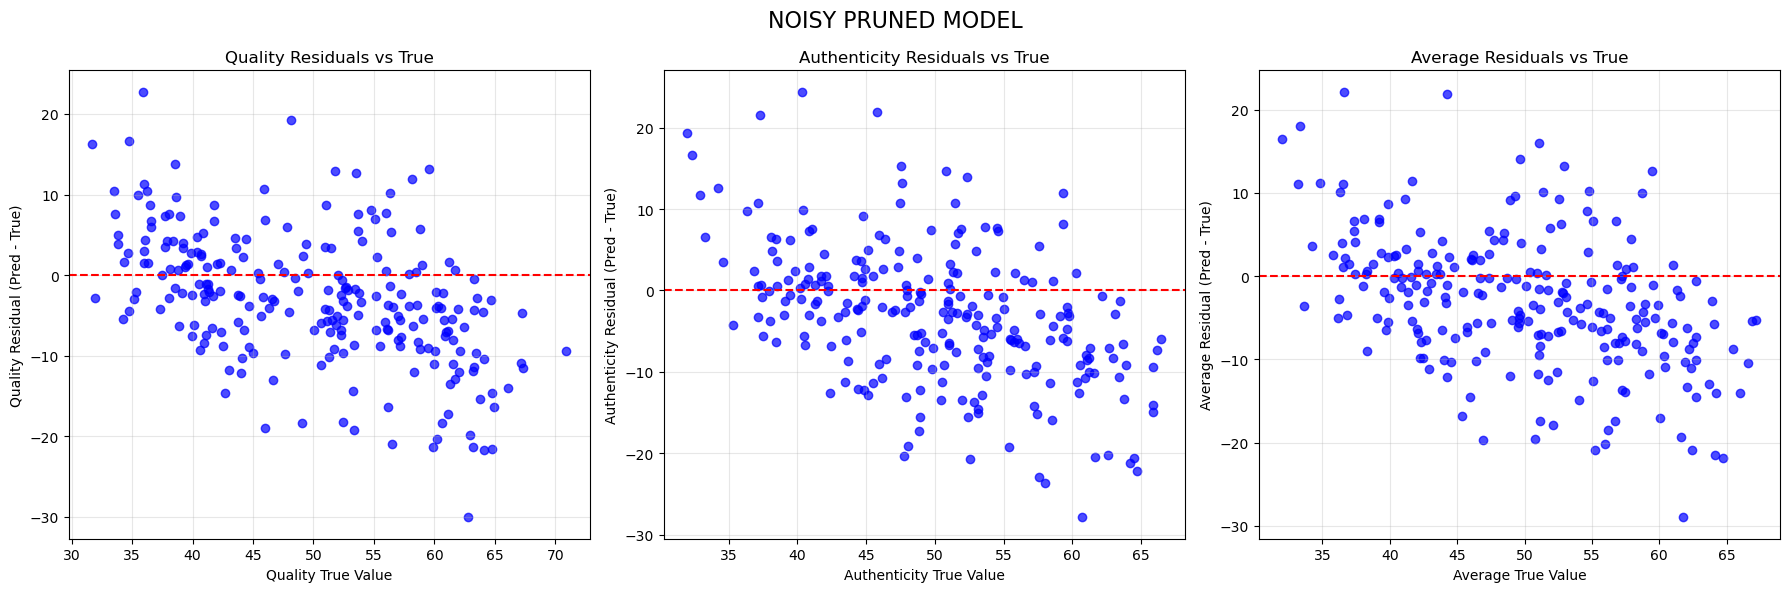

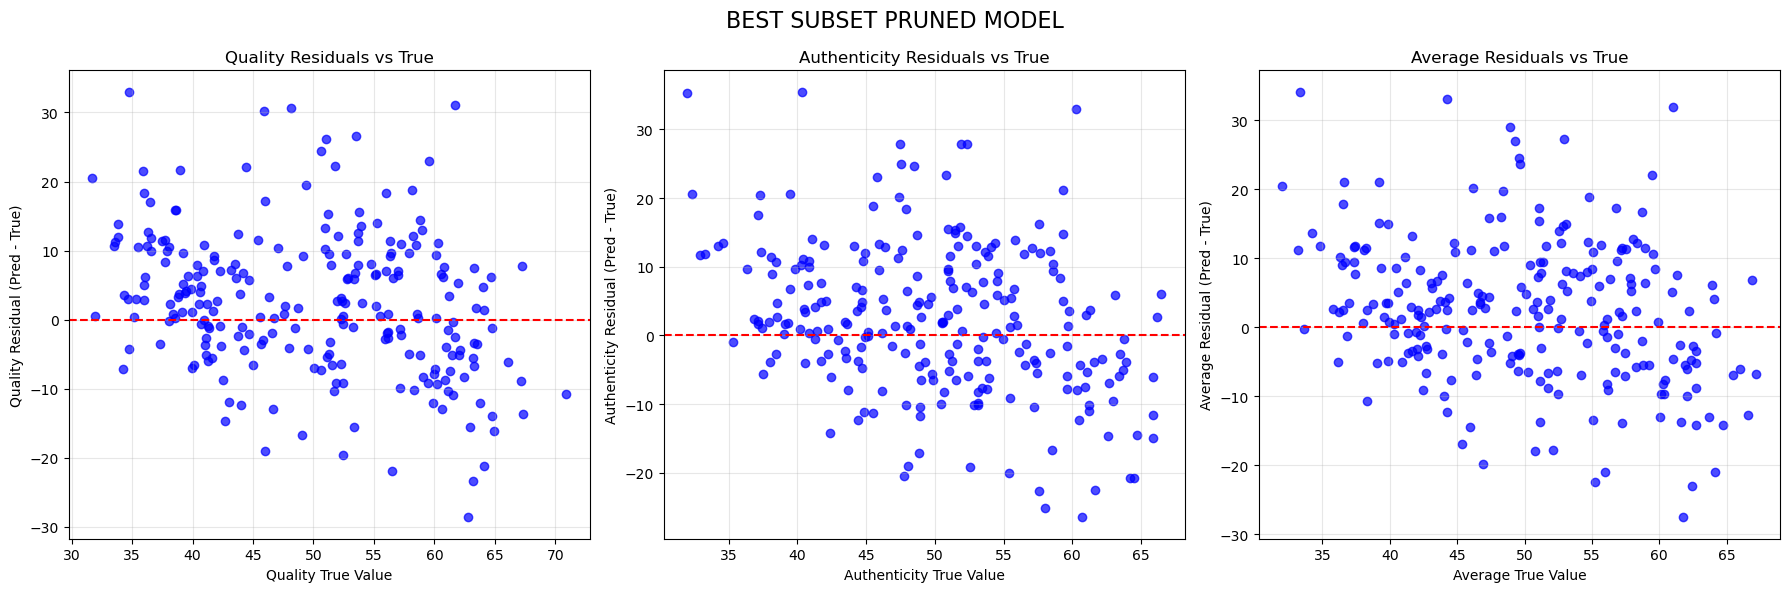

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.gridspec as gridspec


def compute_metrics(model, dataloader, device):
    """
    Computes metrics for model evaluation including residuals.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing predictions, ground truth, and calculated metrics
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Collect predictions and ground truth
    pred_list = []
    true_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            pred_list.append(outputs.cpu())
            true_list.append(labels)
    
    # Concatenate batches
    predictions = torch.cat(pred_list, dim=0).numpy()
    ground_truth = torch.cat(true_list, dim=0).numpy()
    
    # Extract quality and authenticity scores
    pred_quality = predictions[:, 0]
    true_quality = ground_truth[:, 0]
    
    pred_authenticity = predictions[:, 1]
    true_authenticity = ground_truth[:, 1]
    
    # Calculate average scores
    true_avg = (true_quality + true_authenticity) / 2
    pred_avg = (pred_quality + pred_authenticity) / 2
    
    # Calculate residuals (important for understanding distribution)
    quality_residuals = pred_quality - true_quality
    auth_residuals = pred_authenticity - true_authenticity
    avg_residuals = pred_avg - true_avg
    
    # Calculate correlation metrics for individual scores
    quality_spearman, q_pvalue = spearmanr(pred_quality, true_quality)
    auth_spearman, a_pvalue = spearmanr(pred_authenticity, true_authenticity)
    avg_spearman, avg_pvalue = spearmanr(true_avg, pred_avg)
    
    # Calculate R² scores
    quality_r2 = r2_score(true_quality, pred_quality)
    auth_r2 = r2_score(true_authenticity, pred_authenticity)
    avg_r2 = r2_score(true_avg, pred_avg)
    
    # Calculate RMSE scores
    quality_rmse = np.sqrt(mean_squared_error(true_quality, pred_quality))
    auth_rmse = np.sqrt(mean_squared_error(true_authenticity, pred_authenticity))
    avg_rmse = np.sqrt(mean_squared_error(true_avg, pred_avg))
    
    # Create results dictionary
    results = {
        'predictions': {
            'quality': pred_quality,
            'authenticity': pred_authenticity,
            'average': pred_avg
        },
        'ground_truth': {
            'quality': true_quality,
            'authenticity': true_authenticity,
            'average': true_avg
        },
        'residuals': {
            'quality': quality_residuals,
            'authenticity': auth_residuals,
            'average': avg_residuals
        },
        'metrics': {
            'quality': {
                'spearman': quality_spearman,
                'p_value': q_pvalue,
                'r2': quality_r2,
                'rmse': quality_rmse
            },
            'authenticity': {
                'spearman': auth_spearman,
                'p_value': a_pvalue,
                'r2': auth_r2,
                'rmse': auth_rmse
            },
            'average': {
                'spearman': avg_spearman,
                'p_value': avg_pvalue,
                'r2': avg_r2,
                'rmse': avg_rmse
            }
        }
    }
    
    return results


def visualize_correlations(results, save_path=None, title=""):
    """
    Visualizes correlations and distributions from computed metrics.
    
    Args:
        results (dict): Results dictionary from compute_metrics function
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    # Extract data from results dictionary
    pred_quality = results['predictions']['quality']
    true_quality = results['ground_truth']['quality']
    
    pred_authenticity = results['predictions']['authenticity']
    true_authenticity = results['ground_truth']['authenticity']
    
    pred_avg = results['predictions']['average']
    true_avg = results['ground_truth']['average']
    
    quality_residuals = results['residuals']['quality']
    auth_residuals = results['residuals']['authenticity']
    avg_residuals = results['residuals']['average']
    
    # Get metrics
    quality_metrics = results['metrics']['quality']
    auth_metrics = results['metrics']['authenticity']
    avg_metrics = results['metrics']['average']
    
    # Create a larger figure with 3 rows (metrics, scatter plots, residuals)
    fig = plt.figure(figsize=(16, 18))
    fig.suptitle(title, fontsize=16)
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
    
    # Row 1: Scatter plots for quality, authenticity, average
    ax_quality = plt.subplot(gs[0, 0])
    ax_auth = plt.subplot(gs[0, 1]) 
    ax_avg = plt.subplot(gs[0, 2])
    
    # Row 2: Residual plots (residuals vs. predicted values)
    ax_quality_res = plt.subplot(gs[1, 0])
    ax_auth_res = plt.subplot(gs[1, 1])
    ax_avg_res = plt.subplot(gs[1, 2])
    
    # Row 3: Residual histograms
    ax_quality_hist = plt.subplot(gs[2, 0])
    ax_auth_hist = plt.subplot(gs[2, 1])
    ax_avg_hist = plt.subplot(gs[2, 2])
    
    # Function to plot correlation scatter plot
    def plot_correlation(ax, true_vals, pred_vals, metrics, title_suffix):
        ax.scatter(true_vals, pred_vals, alpha=0.7, color='blue')
        
        # Add identity line
        min_val = min(min(true_vals), min(pred_vals))
        max_val = max(max(true_vals), max(pred_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
        
        # Add regression line
        z = np.polyfit(true_vals, pred_vals, 1)
        p = np.poly1d(z)
        x_sorted = np.sort(true_vals)
        ax.plot(x_sorted, p(x_sorted), 'g-', label=f'Best fit (y = {z[0]:.3f}x + {z[1]:.3f})')
        
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title(f'{title_suffix}\nSpearman ρ = {metrics["spearman"]:.4f}, R² = {metrics["r2"]:.4f}, RMSE = {metrics["rmse"]:.4f}')
        ax.grid(alpha=0.3)
        ax.legend(loc='upper left')
    
    # Function to plot residuals vs predicted
    def plot_residuals(ax, pred_vals, residuals, title_suffix):
        ax.scatter(pred_vals, residuals, alpha=0.7, color='orange')
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('Residual (Pred - True)')
        ax.set_title(f'{title_suffix} Residuals vs Predicted')
        ax.grid(alpha=0.3)
    
    # Function to plot residual histogram
    def plot_residual_hist(ax, residuals, title_suffix):
        ax.hist(residuals, bins=20, alpha=0.7, color='green')
        ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlabel('Residual Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{title_suffix} Residual Distribution')
        # Add mean and std as text
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        ax.text(0.05, 0.95, f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Plot all charts
    plot_correlation(ax_quality, true_quality, pred_quality, quality_metrics, 'Quality Score')
    plot_correlation(ax_auth, true_authenticity, pred_authenticity, auth_metrics, 'Authenticity Score')
    plot_correlation(ax_avg, true_avg, pred_avg, avg_metrics, 'Average Score')
    
    plot_residuals(ax_quality_res, pred_quality, quality_residuals, 'Quality')
    plot_residuals(ax_auth_res, pred_authenticity, auth_residuals, 'Authenticity')
    plot_residuals(ax_avg_res, pred_avg, avg_residuals, 'Average')
    
    plot_residual_hist(ax_quality_hist, quality_residuals, 'Quality')
    plot_residual_hist(ax_auth_hist, auth_residuals, 'Authenticity')
    plot_residual_hist(ax_avg_hist, avg_residuals, 'Average')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    # Print summary statistics
    print("-" * 50)
    print(f"MODEL EVALUATION: {title}")
    print("-" * 50)
    print(f"Quality Score - Spearman ρ: {quality_metrics['spearman']:.4f} (p-value: {quality_metrics['p_value']:.4g}), R²: {quality_metrics['r2']:.4f}, RMSE: {quality_metrics['rmse']:.4f}")
    print(f"Authenticity Score - Spearman ρ: {auth_metrics['spearman']:.4f} (p-value: {auth_metrics['p_value']:.4g}), R²: {auth_metrics['r2']:.4f}, RMSE: {auth_metrics['rmse']:.4f}")
    print(f"Average Score - Spearman ρ: {avg_metrics['spearman']:.4f} (p-value: {avg_metrics['p_value']:.4g}), R²: {avg_metrics['r2']:.4f}, RMSE: {avg_metrics['rmse']:.4f}")

def plot_correlations(model, dataloader, device, save_path=None, title=""):
    """
    Wrapper function that computes metrics and visualizes correlations.
    Maintains backward compatibility with the original function.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
        
    Returns:
        dict: Dictionary containing correlation metrics
    """
    # Compute metrics
    results = compute_metrics(model, dataloader, device)
    
    # Visualize results
    visualize_correlations(results, save_path, title)
    
    # Return metrics for backward compatibility
    return results['metrics']

def true_vs_error_plot(results, save_path=None, title=""):
    """
    Create a plot of the true scores vs. the prediction errors (residuals) for the model.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    
    # Extract residuals
    quality_residuals = results['residuals']['quality']
    auth_residuals = results['residuals']['authenticity']
    avg_residuals = results['residuals']['average']
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot residuals
    axes[0].scatter(results['ground_truth']['quality'], quality_residuals, alpha=0.7, color='blue')
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Quality True Value')
    axes[0].set_ylabel('Quality Residual (Pred - True)')
    axes[0].set_title('Quality Residuals vs True')
    axes[0].grid(alpha=0.3)
    
    axes[1].scatter(results['ground_truth']['authenticity'], auth_residuals, alpha=0.7, color='blue')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Authenticity True Value')
    axes[1].set_ylabel('Authenticity Residual (Pred - True)')
    axes[1].set_title('Authenticity Residuals vs True')
    axes[1].grid(alpha=0.3)
    
    axes[2].scatter(results['ground_truth']['average'], avg_residuals, alpha=0.7, color='blue')
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_xlabel('Average True Value')
    axes[2].set_ylabel('Average Residual (Pred - True)')
    axes[2].set_title('Average Residuals vs True')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
def pred_vs_error_plot(results, save_path=None, title=""):
    """
    Create a plot of the true scores vs. the prediction errors (residuals) for the model.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    
    # Extract residuals
    quality_residuals = results['residuals']['quality']
    auth_residuals = results['residuals']['authenticity']
    avg_residuals = results['residuals']['average']
    
    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot residuals
    axes[0].scatter(results['predictions']['quality'], quality_residuals, alpha=0.7, color='blue')
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Quality Predicted Value')
    axes[0].set_ylabel('Quality Residual (Pred - True)')
    axes[0].set_title('Quality Residuals vs Predicted')
    axes[0].grid(alpha=0.3)
    
    axes[1].scatter(results['predictions']['authenticity'], auth_residuals, alpha=0.7, color='blue')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Authenticity Predicted Value')
    axes[1].set_ylabel('Authenticity Residual (Pred - True)')
    axes[1].set_title('Authenticity Residuals vs Predicted')
    axes[1].grid(alpha=0.3)
    
    axes[2].scatter(results['predictions']['average'], avg_residuals, alpha=0.7, color='blue')
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_xlabel('Average Predicted Value')
    axes[2].set_ylabel('Average Residual (Pred - True)')
    axes[2].set_title('Average Residuals vs Predicted')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()



BASELINE_PATH_NAME = 'Plots/baseline_correlation.png'
NOISY_PATH_NAME = 'Plots/noisy_pruned_correlation.png'
NEGATIVE_PATH_NAME = 'Plots/negative_impact_correlation.png'

baseline_results = compute_metrics(baseline_model, test_dataloader, device)
noisy_results = compute_metrics(noisy_pruned_model, test_dataloader, device)
negative_results = compute_metrics(negative_impact_pruned_model, test_dataloader, device)

true_vs_error_plot(baseline_results,save_path="Plots/baseline_true_vs_error.png", title="BASELINE MODEL")
true_vs_error_plot(noisy_results, save_path="Plots/noisy_pruned_true_vs_error.png", title="NOISY PRUNED MODEL")
true_vs_error_plot(negative_results, save_path="Plots/best_subset_true_vs_error.png", title="BEST SUBSET PRUNED MODEL")

pred_vs_error_plot(baseline_results,save_path="Plots/baseline_pred_vs_error.png", title="BASELINE MODEL")
pred_vs_error_plot(noisy_results, save_path="Plots/noisy_pruned_pred_vs_error.png", title="NOISY PRUNED MODEL")
pred_vs_error_plot(negative_results, save_path="Plots/best_subset_pred_vs_error.png", title="BEST SUBSET PRUNED MODEL")

# For direct use with the original interface (backward compatibility):
plot_correlations(baseline_model, test_dataloader, device, save_path=BASELINE_PATH_NAME, title="BASELINE MODEL")
plot_correlations(noisy_pruned_model, test_dataloader, device, save_path=NOISY_PATH_NAME, title="NOISY PRUNED MODEL")
plot_correlations(negative_impact_pruned_model, test_dataloader, device, save_path=NEGATIVE_PATH_NAME, title="NEGATIVE IMPACT PRUNED MODEL")

In [15]:
# print the metrics for the different models
print("Baseline Model Metrics")
print(baseline_metrics)
print("------------------")
print("Noisy Pruned Model Metrics")
print(noisy_pruned_metrics)
print("------------------")
print("Best Subset Pruned Model Metrics")
print(best_subset_pruned_metrics)


Baseline Model Metrics
{'predictions': {'quality': array([31.26429 , 43.293312, 44.407017, 32.084553, 48.74651 , 38.90922 ,
       28.55183 , 40.770218, 38.07517 , 56.404842, 51.281208, 49.464226,
       35.77493 , 52.332817, 37.937263, 33.720104, 35.659702, 32.90298 ,
       53.990196, 34.87341 , 31.558455, 39.962517, 35.448704, 46.10413 ,
       40.28776 , 44.071434, 52.87537 , 42.20436 , 43.09146 , 32.28402 ,
       33.372944, 30.848032, 44.1665  , 45.705074, 46.09159 , 38.387543,
       47.47097 , 42.26145 , 43.6972  , 66.41694 , 51.034138, 33.618942,
       53.362495, 39.2513  , 36.48638 , 46.201557, 41.735806, 50.04926 ,
       40.680958, 33.24904 , 46.01587 , 41.513184, 50.82249 , 50.380642,
       45.335403, 58.610874, 54.18853 , 39.293797, 46.49085 , 36.790077,
       33.059208, 38.952427, 35.35283 , 39.052444, 56.273003, 26.46561 ,
       34.91393 , 32.688343, 43.22824 , 48.51039 , 47.382694, 48.797535,
       39.902065, 39.42747 , 31.7194  , 35.154804, 36.37078 , 44.856495,


# Test RSA on the models (baseline and pruned models)

### Definition of the models for RSA

In [5]:
BASELINE_MODEL_NAME = 'Models/VGG-16_finetuned_regression.pth'
NOISY_PRUNED_MODEL_PATH = 'Models/noise_out_pruned_model.pth'
NEGATIVE_IMPACT_PRUNED_MODEL_PATH = 'Models/negative_impact_pruned_model.pth'

baseline_model = QualityPredictor()
baseline_model.load_state_dict(torch.load(BASELINE_MODEL_NAME, weights_only=True))

noisy_pruned_model = QualityPredictor()
noisy_pruned_model.load_state_dict(torch.load(NOISY_PRUNED_MODEL_PATH, weights_only=True))

negative_impact_pruned_model = QualityPredictor()
negative_impact_pruned_model.load_state_dict(torch.load(NEGATIVE_IMPACT_PRUNED_MODEL_PATH,weights_only=True))

<All keys matched successfully>

## Helper functions for RSA

In [52]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

In [53]:

class FeatureMapHook:
    """Hook to extract feature maps from neural network layers."""
    
    def __init__(self):
        self.feature_maps = []
    
    def __call__(self, module, input, output):
        # Detach from computation graph and move to CPU
        self.feature_maps.append(output.detach().cpu())

def get_feature_maps(model, dataloader, layer_name, device):
    """
    Extracts the feature maps of a specific layer from a model.
    
    Args:
        model (nn.Module): The neural network model.
        dataloader (DataLoader): DataLoader for evaluation.
        layer_name (str): The name of the layer to extract feature maps from.
        device (str): Device to run the model on ('cuda' or 'cpu').
        
    Returns:
        np.ndarray: The feature maps as a numpy array with shape (240, num_features).
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Register a hook to extract feature maps
    hook = FeatureMapHook()
    target_layer = dict(model.named_modules())[layer_name]
    hook_handle = target_layer.register_forward_hook(hook)
    
    # Forward pass to extract feature maps from the dataloader
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    # Remove the hook
    hook_handle.remove()
    
    # Process the feature maps to get the desired shape
    all_features = []
    
    for batch_features in hook.feature_maps:
        # Handle different possible output formats (accommodate different layer types)
        if len(batch_features.shape) == 4:  # Conv layers: [batch_size, channels, height, width]
            batch_size, channels, height, width = batch_features.shape
            # Flatten spatial dimensions and create one feature vector per sample
            batch_features = batch_features.reshape(batch_size, channels * height * width)
        elif len(batch_features.shape) == 2:  # Linear layers: [batch_size, features]
            pass  # Already in the right format
        
        # Add batch features to our collection
        all_features.append(batch_features)
    
    # Concatenate all batches and convert to numpy
    features_tensor = torch.cat(all_features, dim=0)
    
    # Ensure we have exactly the number of samples we expect in the dataloader 
    assert features_tensor.shape[0] == len(dataloader.dataset) 
    
    # Convert to numpy array
    features_array = features_tensor.numpy()
    
    return features_array
def compute_similarity_matrix(features):
    """
    Compute a similarity matrix from feature embeddings.
    Works with both convolutional features (4D) and FC features (2D).
    
    Args:
        features: numpy array - either shape (n_samples, n_channels, height, width)
                 or shape (n_samples, n_features)
        
    Returns:
        similarity_matrix: numpy array of shape (n_samples, n_samples)
    """
    # Check the dimensionality of features
    n_samples = features.shape[0]
    
    # If features are from convolutional layer (4D), reshape to 2D
    if len(features.shape) == 4:
        features_flat = features.reshape(n_samples, -1)
    else:
        # Features are already 2D (from FC layer)
        features_flat = features
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(features_flat)
    
    return similarity_matrix

def compute_quality_difference_matrix(quality_scores):
    """
    Compute a matrix of quality differences between all pairs of samples.
    
    Args:
        quality_scores: numpy array of shape (n_samples,) containing quality scores
        
    Returns:
        difference_matrix: numpy array of shape (n_samples, n_samples)
    """
    n_samples = quality_scores.shape[0]
    difference_matrix = np.zeros((n_samples, n_samples))
    
    # Compute absolute differences between all pairs
    for i in range(n_samples):
        for j in range(n_samples):
            difference_matrix[i, j] = abs(quality_scores[i] - quality_scores[j])
            
    return difference_matrix

def get_upper_triangle(matrix):
    """
    Extract the upper triangle of a matrix (excluding diagonal).
    
    Args:
        matrix: numpy array of shape (n, n)
        
    Returns:
        upper_triangle: flattened upper triangle values
    """
    indices = np.triu_indices_from(matrix, k=1)
    return matrix[indices]

def calculate_fit(similarity_matrix, quality_diff_matrix):
    """
    Calculate the fit between similarity and quality difference matrices.
    
    Args:
        similarity_matrix: numpy array of shape (n_samples, n_samples)
        quality_diff_matrix: numpy array of shape (n_samples, n_samples)
        
    Returns:
        correlation: Spearman correlation coefficient between the matrices
        p_value: p-value of the correlation
    """
    # Extract upper triangles (excluding diagonal)
    sim_upper = get_upper_triangle(similarity_matrix)
    qual_upper = get_upper_triangle(quality_diff_matrix)
    
    # Compute correlation (negative since higher similarity should correspond to lower difference)
    correlation, p_value = spearmanr(sim_upper, qual_upper)
    
    # We're expecting a negative correlation (higher similarity → lower quality difference)
    # so we return the negative correlation value for easier interpretation
    return -correlation, p_value


In [47]:
# Get feature maps
baseline_features = get_feature_maps(baseline_model, test_dataloader, 'fc1.3', device)

noisy_pruned_features = get_feature_maps(noisy_pruned_model, test_dataloader, 'fc1.3', device)

negative_impact_features = get_feature_maps(negative_impact_pruned_model, test_dataloader, 'fc1.3', device)

# Extract quality scores
quality_scores_list = []
with torch.no_grad():
	for _, labels in test_dataloader:
		quality_scores_list.append(labels[:, 0])  # First column contains quality scores
q_scores = torch.cat(quality_scores_list).numpy()




In [ ]:
# Compute similarity matrices
baseline_similarity = compute_similarity_matrix(baseline_features)
noisy_similarity = compute_similarity_matrix(noisy_pruned_features)
negative_impact_similarity = compute_similarity_matrix(negative_impact_features)

# Compute quality difference matrices
quality_diff_matrix = compute_quality_difference_matrix(q_scores)

# Calculate fit between similarity and quality difference matrices
baseline_fit = calculate_fit(baseline_similarity, quality_diff_matrix)
noisy_fit = calculate_fit(noisy_similarity, quality_diff_matrix)
negative_impact_fit = calculate_fit(negative_impact_similarity, quality_diff_matrix)

print("Baseline Model Fit:")
print(f"Correlation: {baseline_fit[0]:.4f}")
print("------------------")
print("RSME Noise-out Pruned Model Fit:")
print(f"Correlation: {noisy_fit[0]:.4f}")
print("------------------")
print("RSME Negative Impact Pruned Model Fit:")
print(f"Correlation: {negative_impact_fit[0]:.4f}")


Similarity matrices shape:
Baseline: (240, 240)
Noisy Pruned: (240, 240)
Baseline Model Fit:
Correlation: 0.0448
------------------
RSME Noise-out Pruned Model Fit:
Correlation: 0.0455
------------------
RSME Negative Impact Pruned Model Fit:
Correlation: 0.0394
